In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from sympy.utilities.lambdify import lambdify
from matplotlib import rcParams
import casadi as ca
import do_mpc

# ------------------------------------------------------------------
# 1. Define the dynamics symbolically in SymPy. Copied from ABSymbolicCalc.py which may become deprecated.


# ------------------------------------------------------------------
# 1. State symbols (angular + translational)
# ------------------------------------------------------------------
print("Initializing state space model...")

psi,   theta,   phi   = sp.symbols('psi theta phi', real=True)
psi_d, theta_d, phi_d = sp.symbols('psi_dot theta_dot phi_dot', real=True)
psi_dd, theta_dd, phi_dd = sp.symbols('psi_dd theta_dd phi_dd', real=True)

r_x, r_y, r_z = sp.symbols('r_x r_y r_z', real=True)
v_x, v_y, v_z = sp.symbols('v_x v_y v_z', real=True)
r_rcs = sp.symbols('r_rcs', real=True)  # RCS offset

# Inputs: thrust magnitude + two RCS thrusters + gimbal (a, b) & derivatives
T, R1, R2, a, b, a_d, b_d, a_dd, b_dd = sp.symbols('T R1 R2 a b a_dot b_dot a_ddot b_ddot', real=True)

# Aerodynamic / physical constants
rho, C_d, A_ref = sp.symbols('rho cDrag areaVar', real=True)
m = sp.symbols('m', real=True)

# Offsets
r_cx, r_cy, r_cz = sp.symbols('rc_x rc_y rc_z', real=True)
r_tx, r_ty, r_tz = sp.symbols('rt_x rt_y rt_z', real=True)

# Inertia tensor components
Ixx,Iyy,Izz,Ixy,Ixz,Iyz = sp.symbols('Ixx Iyy Izz Ixy Ixz Iyz', real=True)
Ixx_s,Iyy_s,Izz_s,Ixy_s,Ixz_s,Iyz_s = sp.symbols('Ixx_s Iyy_s Izz_s Ixy_s Ixz_s Iyz_s', real=True)
Ixx_a,Iyy_a,Izz_a,Ixy_a,Ixz_a,Iyz_a = sp.symbols('Ixx_a Iyy_a Izz_a Ixy_a Ixz_a Iyz_a', real=True)
Ixx_b,Iyy_b,Izz_b,Ixy_b,Ixz_b,Iyz_b = sp.symbols('Ixx_b Iyy_b Izz_b Ixy_b Ixz_b Iyz_b', real=True)

# ------------------------------------------------------------------
# 2. Assemble state & input vectors
# ------------------------------------------------------------------
full_state = sp.Matrix([
    r_x, r_y, r_z,
    v_x, v_y, v_z,
    psi, theta, phi,
    psi_d, theta_d, phi_d
])

velocity_wf  = sp.Matrix([v_x, v_y, v_z])
ang_vel_wf   = sp.Matrix([psi_d, theta_d, phi_d])

full_input = sp.Matrix([T, R1, R2, a, b])
# full_input = sp.Matrix([T, R1, R2, a, b])

# Offsets & inertia matrices
r_c = sp.Matrix([r_cx, r_cy, r_cz])
r_t = sp.Matrix([r_tx, r_ty, r_tz])

I      = sp.Matrix([[Ixx,  Ixy,  Ixz],
                    [Ixy,  Iyy,  Iyz],
                    [Ixz,  Iyz,  Izz]])
I_s    = sp.Matrix([[Ixx_s, Ixy_s, Ixz_s],
                    [Ixy_s, Iyy_s, Iyz_s],
                    [Ixz_s, Iyz_s, Izz_s]])
I_a    = sp.Matrix([[Ixx_a, Ixy_a, Ixz_a],
                    [Ixy_a, Iyy_a, Iyz_a],
                    [Ixz_a, Iyz_a, Izz_a]])
I_b    = sp.Matrix([[Ixx_b, Ixy_b, Ixz_b],
                    [Ixy_b, Iyy_b, Iyz_b],
                    [Ixz_b, Iyz_b, Izz_b]])

# placeholder subsitutions, make sure to match with dynamics model values
r_c = r_c.subs({r_cx: 0, r_cy: 0, r_cz: 0.1})
r_t = r_t.subs({r_tx: 0, r_ty: 0, r_tz: -0.1})
rho = rho.subs({rho: 1.225})
# TODO: implement 3-axis cD instead of 1D
C_d = C_d.subs({C_d: 0.5})
A_ref = A_ref.subs({A_ref: 0.7})
m = m.subs({m: 0.7})
r_rcs = r_rcs.subs({r_rcs: 0.1})
I = I.subs({Ixx: 1, Ixy: 0, Ixz: 0, Iyy:1, Iyz: 0, Izz:1})
I_s = I_s.subs({Ixx_s: 0.7, Ixy_s: 0, Ixz_s: 0, Iyy_s:0.7, Iyz_s: 0, Izz_s:0.7})
I_a = I_a.subs({Ixx_a: 0.1, Ixy_a: 0, Ixz_a: 0, Iyy_a:0.1, Iyz_a: 0, Izz_a:0.1})
I_b = I_b.subs({Ixx_b: 0.1, Ixy_b: 0, Ixz_b: 0, Iyy_b:0.1, Iyz_b: 0, Izz_b:0.1})

# ------------------------------------------------------------------
# 3. Rotation matrices (world→body, Z‑Y‑X extrinsic)
# ------------------------------------------------------------------
R_x = sp.Matrix([[1, 0, 0],
                    [0, sp.cos(psi), -sp.sin(psi)],
                    [0, sp.sin(psi),  sp.cos(psi)]])

R_y = sp.Matrix([[ sp.cos(theta), 0, sp.sin(theta)],
                    [              0, 1,              0],
                    [-sp.sin(theta), 0, sp.cos(theta)]])

R_z = sp.Matrix([[ sp.cos(phi), -sp.sin(phi), 0],
                    [ sp.sin(phi),  sp.cos(phi), 0],
                    [           0,            0, 1]])

R_bf = sp.simplify(R_z * R_y * R_x)  # body←world
R_wf = R_bf.T                        # world←body

# ------------------------------------------------------------------
# 4. Forces (body frame)
# ------------------------------------------------------------------
thrust_b = sp.Matrix([
    T*sp.cos(b)*sp.sin(a),
    T*sp.sin(b),
    -T*sp.cos(b)*sp.cos(a)
])

vel_b   = R_bf * velocity_wf
vel_mag = sp.sqrt(vel_b.dot(vel_b))
# Guard against a zero‑velocity singularity (sqrt'(0) is undefined)
eps_vel = 1e-8  # small positive constant
vel_mag = sp.sqrt(vel_b.dot(vel_b) + eps_vel)

Fd_b = (sp.Rational(1,2)*rho*C_d*A_ref*vel_mag) * vel_b

# ------------------------------------------------------------------
# 5. Torques & angular acceleration
# ------------------------------------------------------------------
aero_tau_b   = r_c.cross(Fd_b)
thrust_tau_b = r_t.cross(thrust_b)
# R1 is clockwise, R2 is counterclockwise. Only points one way.
rcs_tau_b = sp.Matrix([
    0,
    0,
    r_rcs*R1 - r_rcs*R2,
])
tau_net_b    = aero_tau_b + thrust_tau_b + rcs_tau_b

tau_net_w = R_wf * tau_net_b

# Gyro + TVC terms
I_s_w = R_wf*I_s*R_wf.T
I_a_w = R_wf*I_a*R_wf.T
I_b_w = R_wf*I_b*R_wf.T

gyro_tau_s = ang_vel_wf.cross(I_s_w*ang_vel_wf)

ang_vel_a_b = sp.Matrix([a_d, 0, 0])
ang_vel_b_b = sp.Matrix([0, b_d, 0])
# ang_vel_a_w = R_wf*ang_vel_a_b + ang_vel_wf
# ang_vel_b_w = R_wf*ang_vel_b_b + ang_vel_wf
# gyro_tau_a  = ang_vel_a_w.cross(I_a_w*ang_vel_a_w)
# gyro_tau_b  = ang_vel_b_w.cross(I_b_w*ang_vel_b_w)

ang_acc_a_b = sp.Matrix([a_dd, 0, 0])
ang_acc_b_b = sp.Matrix([0, b_dd, 0])
# m_tau_a_w   = R_wf * (I_a*ang_acc_a_b)
# m_tau_b_w   = R_wf * (I_b*ang_acc_b_b)

# tau_net_w = (tau_net_w
#                 - (gyro_tau_s + gyro_tau_a + gyro_tau_b)
#                 + m_tau_a_w + m_tau_b_w)
tau_net_w = (tau_net_w - gyro_tau_s)

ang_accel_w = I.inv() * tau_net_w

# Jacobians (angular part)
A4 = ang_accel_w.jacobian(full_state)
B4 = ang_accel_w.jacobian(full_input)

# ------------------------------------------------------------------
# 6. Translational acceleration
# ------------------------------------------------------------------
g_w = sp.Matrix([0, 0, -9.80665])
thrust_w = R_wf * thrust_b
Fd_w     = R_wf * Fd_b
accel_w  = (thrust_w - Fd_w)/m + g_w

# f function 
f_sym = sp.Matrix([
    v_x,
    v_y,
    v_z,
    accel_w[0],
    accel_w[1],
    accel_w[2],
    psi_d,
    theta_d,
    phi_d,
    ang_accel_w[0],
    ang_accel_w[1],
    ang_accel_w[2]
])
x_sym = sp.Matrix([
    r_x, r_y, r_z,
    v_x, v_y, v_z,
    psi, theta, phi,
    psi_d, theta_d, phi_d
])
u_sym = sp.Matrix([T, R1, R2, a, b])
print("State space model initialized.")

print("Initializing MPC...")
# Placeholder for the MPC initialization function
# pass
# Convert RHS to CasADi MX lambda function (needed, don't know why)

# const_subs = {}
# for s in param_syms:
#     if   str(s) == 'rho':   const_subs[s] = rho_val
#     elif str(s) == 'cDrag':   const_subs[s] = C_d_val
#     elif str(s) == 'areaVar': const_subs[s] = A_ref_val
#     elif str(s) == 'm':     const_subs[s] = m_val
# f_sym_num = f_sym.subs(const_subs)

# Mapping for SymPy functions that need explicit CasADi equivalents
custom_map = {
'Abs' : ca.fabs,
'sqrt': ca.sqrt,
'sin' : ca.sin,
'cos' : ca.cos,
'tan' : ca.tan,
'asin': ca.asin,
'acos': ca.acos,
'atan': ca.atan,
'exp' : ca.exp,
'log' : ca.log,
'sign': ca.sign,
'pi'  : ca.pi,     # SymPy constant → CasADi constant
}


dt_disc = 0.01  # sampling period (s) - match with dynamics model (?)

# ------------------ Helper to build k2, k3, k4 symbolically ---------------------------

# (r_x, r_y, r_z,
# v_x, v_y, v_z,
# psi, theta, phi,
# psi_d, theta_d, phi_d) = x_sym

# print("Discretizing f_sym...")

# k1 = f_sym
# # print("k1 done.")
# y_half1 = x_sym + (dt_disc/2) * k1
# k2 = f_sym.xreplace(dict(zip(x_sym, y_half1)))
# # print("k2 done.")

# y_half2 = x_sym + (dt_disc/2) * k2
# k3 = f_sym.xreplace(dict(zip(x_sym, y_half2)))
# # print("k3 done.")

# y_full = x_sym + dt_disc * k3
# k4 = f_sym.xreplace(dict(zip(x_sym, y_full)))
# # print("k4 done.")

# f_rk4_sym = x_sym + (dt_disc/6) * (k1 + 2*k2 + 2*k3 + k4)
# # print("f_rk4_sym done.")

# CasADi callable -----------------------------------------
# Convert SymPy Matrix to a flat list of expressions
# Flatten state & input matrices into scalar symbol lists ----------------------
x_syms_flat = list(x_sym)
u_syms_flat = list(u_sym)
f_sym_flat = list(f_sym)  #   <‑‑ outputs as a *Python* list of SymPy exprs

# Lambdify into a regular Python function returning a list of MX scalars -------
f_lamb = lambdify(x_syms_flat + u_syms_flat,
                    f_sym_flat,
                    modules=[custom_map])

# kept = set(x_sym) | set(u_sym)

# # symbols that should have been substituted
# remaining = f_sym.free_symbols - kept

# if remaining:
#     raise RuntimeError(
#         f"[initialize_mpc] These symbols still need numeric values: {remaining}"
    # )

def f_dt_casadi(x_mx, u_mx):
    """Return CasADi MX column vector f(x,u).  x_mx ∈ ℝ¹²×¹, u_mx ∈ ℝ⁵×¹."""
    # Extract scalar MX components (safe – we iterate over Python ints)
    x_list = [x_mx[i] for i in range(12)]
    u_list = [u_mx[i] for i in range(5)]
    f_list = f_lamb(*x_list, *u_list)  # <- list of 12 MX scalars
    return ca.vertcat(*f_list)          # column vector (12×1 MX)

# ------------------------------------------------------------------
# 3.  Continuous do‑mpc model (for now)
# ------------------------------------------------------------------

print("Creating do-mpc model...")
model = do_mpc.model.Model('continuous')

x_mx = model.set_variable('_x', 'x', shape=(12,1))   # state at k
u_mx = model.set_variable('_u', 'u', shape=(5,1))    # control at k

# print(x_mx)
# print(u_mx)

model.set_rhs('x', f_dt_casadi(x_mx, u_mx))
model.set_expression('y', x_mx)      
print(ca.Function('test', [x_mx, u_mx], [f_dt_casadi(x_mx, u_mx)])())               # full‑state output
model.setup()

# ------------------------------------------------------------------
# 4.  MPC controller 
# ------------------------------------------------------------------

print("Creating do-mpc controller...")
mpc = do_mpc.controller.MPC(model)
mpc.set_param(
    n_horizon = 10,   # 20 steps ahead, adjust if needed. Higher -
    t_step    = dt_disc,   # just for time axis scaling in logs/plotting
    state_discretization = 'collocation',   # Radau collocation (default)
    collocation_type = 'radau',
    collocation_deg  = 3,
    store_full_solution = True,
    # mute Ipopt solver output (will ounly show errors)
    nlpsolver='ipopt',
    nlpsol_opts={
        # ---------- Ipopt’s own options ----------
        'ipopt': {
            'print_level': 0,   # 0 = mute everything
            'sb':          'yes'  # skip the decorative banner
        },
        # ---------- CasADi wrapper options ----------
        'print_time': 0         # don’t show CasADi timing
    },
)

# Reference variable
# x_ref = model.set_variable('_tvp','x_ref',shape=(12,1))

x_ref = np.array([0,0,1,0,0,0,0,0,0,0,0,0])  # desired state at all times
print("Setting up cost function...")
# Q_vel, R_u = 10.0, 1.0
Q = np.diag([0.5, 0.5, 1.0, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
R_vec = [0, 1, 1, 5, 5]
R_u = np.diag(R_vec)
# mpc.set_objective(mterm = Q_vel*(x_mx-x_ref)**2,
#                 lterm = Q_vel*(x_mx-x_ref)**2 + R_u*u_mx**2)
# quadratic cost function with vectors
err = x_mx - x_ref

mpc.set_objective(lterm=ca.mtimes([err.T, Q, err]) + (ca.mtimes([u_mx.T, R_u, u_mx])),
                mterm=ca.mtimes([err.T, Q, err]))

mpc.bounds['lower','_u','u'] = np.array([0.0, 0.0, 0.0, -np.pi/12, -np.pi/12])
mpc.bounds['upper','_u','u'] =  np.array([15.0, 1.0, 1.0, np.pi/12, np.pi/12])
# mpc.bounds['lower', '_u', 'T'] = 0.0
# mpc.bounds['lower', '_u', 'RCS1'] = 0.0
# mpc.bounds['lower', '_u', 'RCS2'] = 0.0
# mpc.bounds['lower', '_u', 'gimbal_a'] = -np.pi/12
# mpc.bounds['lower', '_u', 'gimbal_b'] = -np.pi/12
# mpc.bounds['upper', '_u', 'thrust'] = 15.0
# mpc.bounds['upper', '_u', 'RCS1'] = 1.0
# mpc.bounds['upper', '_u', 'RCS2'] = 1.0
# mpc.bounds['upper', '_u', 'gimbal_a'] = np.pi/12
# mpc.bounds['upper', '_u', 'gimbal_b'] = np.pi/12
mpc.set_rterm(u = np.array(R_vec)) # input penalty


# print("Time varying parameters...")
# Time‑varying parameter template
# not doing this for now
# _tvpt = mpc.get_tvp_template()
# def tvp_fun(t_now):
#     # change these target values to what we need (for now, targeting just hovering at 50 m)
#     # _tvpt['_tvp','x_ref'][:] = np.array([0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0])   # desired state at all times

#     return _tvpt

# mpc.set_tvp_fun(tvp_fun)

mpc.setup()

print("MPC initialized.")

Initializing state space model...
State space model initialized.
Initializing MPC...
Creating do-mpc model...
{'o0': DM([0, 0, 0, 0, 0, -9.80665, 0, 0, 0, 0, 0, 0])}
Creating do-mpc controller...
Setting up cost function...
MPC initialized.


In [9]:

# return mpc

# DEBUGGING. REMOVE LATER (MAYBE)

# estimator - for debugging state space model
estimator = do_mpc.estimator.StateFeedback(model)

# integrated simulator - for debugging state space model 
simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(t_step=dt_disc)
simulator.setup()

x0 = np.zeros((12,1))
simulator.x0 = x0
estimator.x0 = x0

mpc.set_initial_guess()

print("Running simulation...")
for k in range(50):
    
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)

Running simulation...


In [10]:
rcParams['axes.grid'] = True
rcParams['font.size'] = 18

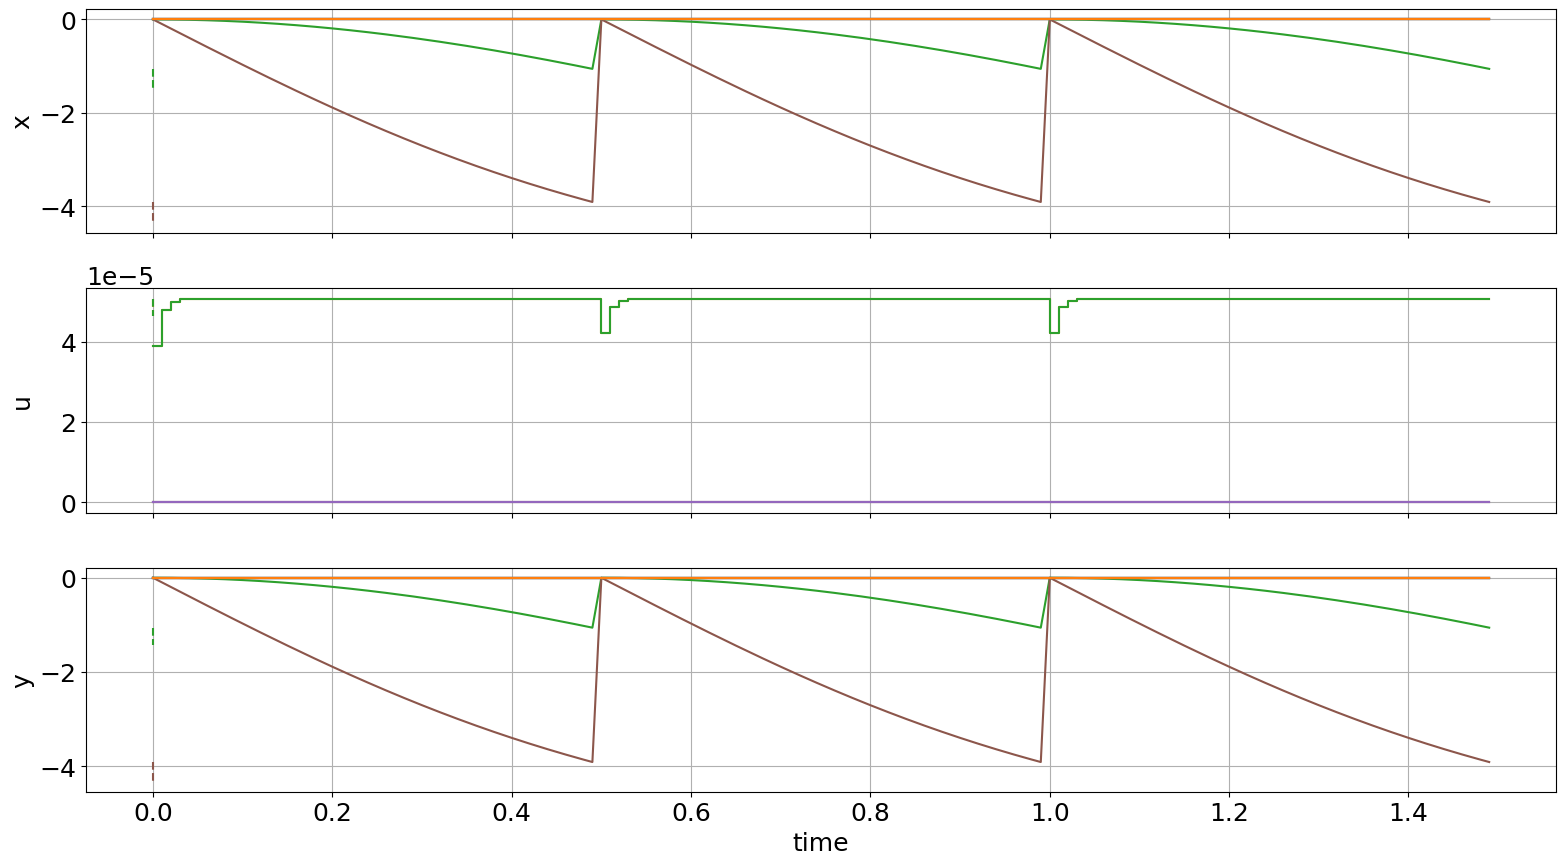

In [11]:
import matplotlib.pyplot as plt
fig, ax, graphics = do_mpc.graphics.default_plot(mpc.data, figsize=(16,9))
graphics.plot_results()
graphics.reset_axes()
plt.show()